In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from transformers import TFElectraModel
from transformers import ElectraTokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from konlpy.tag import Komoran
from collections import Counter

In [2]:
strategy = tf.distribute.get_strategy()

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
for i in range(len(train)):
    train['overview'][i] = train['overview'][i].replace('\n','').replace('\t','').replace('\r','').replace('<br>', '').replace('<br />','').replace('*','')
    train['overview'][i] = train['overview'][i].strip()

for i in range(len(test)):
    test['overview'][i] = test['overview'][i].replace('\n','').replace('\t','').replace('\r','').replace('<br>', '').replace('<br />','').replace('*','')
    test['overview'][i] = test['overview'][i].strip()

In [5]:
train['cat1'].unique()

array(['자연', '레포츠', '음식', '인문(문화/예술/역사)', '숙박', '쇼핑'], dtype=object)

In [6]:
cat1_1 = len(train[train['cat1']=='자연'])
cat1_2 = len(train[train['cat1']=='레포츠'])
cat1_3 = len(train[train['cat1']=='음식'])
cat1_4 = len(train[train['cat1']=='인문(문화/예술/역사)'])
cat1_5 = len(train[train['cat1']=='숙박'])
cat1_6 = len(train[train['cat1']=='쇼핑'])

In [7]:
print(f"cat1=>자연: {cat1_1}")
print(f"cat1=>레포츠: {cat1_2}")
print(f"cat1=>음식: {cat1_3}")
print(f"cat1=>인문: {cat1_4}")
print(f"cat1=>숙박: {cat1_5}")
print(f"cat1=>쇼핑: {cat1_6}")
print(f"전체:{len(train)}, cat1_1~6의 합: {cat1_1+cat1_2+cat1_3+cat1_4+cat1_5+cat1_6}")

cat1=>자연: 1719
cat1=>레포츠: 2611
cat1=>음식: 4912
cat1=>인문: 5614
cat1=>숙박: 1434
cat1=>쇼핑: 696
전체:16986, cat1_1~6의 합: 16986


In [8]:
train_1 = train[train['cat1']=='자연']
train_2 = train[train['cat1']=='레포츠']
train_3 = train[train['cat1']=='음식']
train_4 = train[train['cat1']=='인문(문화/예술/역사)']
train_5 = train[train['cat1']=='숙박']
train_6 = train[train['cat1']=='쇼핑']

In [9]:
print(train_1['cat3'].unique())
print(len(train_1['cat3'].unique()))

['항구/포구' '섬' '자연휴양림' '해수욕장' '산' '희귀동.식물' '수목원' '강' '자연생태관광지' '계곡' '폭포'
 '국립공원' '해안절경' '기암괴석' '호수' '동굴' '도립공원' '군립공원' '약수터' '등대']
20


In [10]:
print(train_2['cat3'].unique())
print(len(train_2['cat3'].unique()))

['골프' '야영장,오토캠핑장' '스키(보드) 렌탈샵' '복합 레포츠' '자동차경주' '자전거하이킹' '썰매장' '요트' '래프팅'
 '승마' '트래킹' '수련시설' '민물낚시' '바다낚시' '수영' '카약/카누' '카지노' '윈드서핑/제트스키' '번지점프'
 '카트' 'MTB' '스케이트' '스카이다이빙' '헹글라이딩/패러글라이딩' '스노쿨링/스킨스쿠버다이빙'
 '인라인(실내 인라인 포함)' '사격장' 'ATV' '빙벽등반' '수상레포츠' '스키/스노보드']
31


In [11]:
print(train_3['cat3'].unique())
print(len(train_3['cat3'].unique()))

['한식' '일식' '바/까페' '채식전문점' '중식' '서양식' '패밀리레스토랑' '클럽']
8


In [12]:
print(train_4['cat3'].unique())
print(len(train_4['cat3'].unique()))

['일반축제' '유적지/사적지' '전시관' '관광단지' '컨벤션' '성' '안보관광' '이색거리' '미술관/화랑' '공원' '박물관'
 '도서관' '공연장' '농.산.어촌 체험' '기념탑/기념비/전망대' '기념관' '유명건물' '유원지' '사찰' '박람회'
 '문화전수시설' '종교성지' '동상' '기타행사' '고택' '문화원' '온천/욕장/스파' '기타' '테마공원' '유람선/잠수함관광'
 '외국문화원' '다리/대교' '분수' '고궁' '민속마을' '전통공연' '문' '식음료' '터널' '문화관광축제' '발전소'
 '대중콘서트' '대형서점' '생가' '영화관' '이색찜질방' '학교' '헬스투어' '연극' '컨벤션센터' '뮤지컬' '이색체험'
 '클래식음악회']
53


In [13]:
print(train_5['cat3'].unique())
print(len(train_5['cat3'].unique()))

['모텔' '한옥스테이' '펜션' '게스트하우스' '홈스테이' '콘도미니엄' '민박' '유스호스텔' '서비스드레지던스']
9


In [14]:
print(train_6['cat3'].unique())
print(len(train_6['cat3'].unique()))

['전문상가' '5일장' '상설시장' '공예,공방' '백화점' '면세점' '특산물판매점']
7


In [15]:
train_1_encoder = LabelEncoder()

train_1_encoder.fit(train_1['cat3'])
train_1['cat3'] = train_1_encoder.transform(train_1['cat3'])

C:\Users\Home\AppData\Local\Temp\ipykernel_2148\2919564192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1['cat3'] = train_1_encoder.transform(train_1['cat3'])


In [16]:
train_2_encoder = LabelEncoder()

train_2_encoder.fit(train_2['cat3'])
train_2['cat3'] = train_2_encoder.transform(train_2['cat3'])

C:\Users\Home\AppData\Local\Temp\ipykernel_2148\115441887.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['cat3'] = train_2_encoder.transform(train_2['cat3'])


In [17]:
train_3_encoder = LabelEncoder()

train_3_encoder.fit(train_3['cat3'])
train_3['cat3'] = train_3_encoder.transform(train_3['cat3'])

C:\Users\Home\AppData\Local\Temp\ipykernel_2148\904434580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3['cat3'] = train_3_encoder.transform(train_3['cat3'])


In [18]:
train_4_encoder = LabelEncoder()

train_4_encoder.fit(train_4['cat3'])
train_4['cat3'] = train_4_encoder.transform(train_4['cat3'])

C:\Users\Home\AppData\Local\Temp\ipykernel_2148\3496481789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_4['cat3'] = train_4_encoder.transform(train_4['cat3'])


In [19]:
train_5_encoder = LabelEncoder()

train_5_encoder.fit(train_5['cat3'])
train_5['cat3'] = train_5_encoder.transform(train_5['cat3'])

C:\Users\Home\AppData\Local\Temp\ipykernel_2148\423763710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_5['cat3'] = train_5_encoder.transform(train_5['cat3'])


In [20]:
train_6_encoder = LabelEncoder()

train_6_encoder.fit(train_6['cat3'])
train_6['cat3'] = train_6_encoder.transform(train_6['cat3'])

C:\Users\Home\AppData\Local\Temp\ipykernel_2148\2536908416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_6['cat3'] = train_6_encoder.transform(train_6['cat3'])


In [21]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [22]:
train_encoded_electra_1 = tokenizer.batch_encode_plus(train_1['overview'].values.tolist())
train_encoded_electra_2 = tokenizer.batch_encode_plus(train_2['overview'].values.tolist())
train_encoded_electra_3 = tokenizer.batch_encode_plus(train_3['overview'].values.tolist())
train_encoded_electra_4 = tokenizer.batch_encode_plus(train_4['overview'].values.tolist())
train_encoded_electra_5 = tokenizer.batch_encode_plus(train_5['overview'].values.tolist())
train_encoded_electra_6 = tokenizer.batch_encode_plus(train_6['overview'].values.tolist())

Token indices sequence length is longer than the specified maximum sequence length for this model (1232 > 512). Running this sequence through the model will result in indexing errors


In [23]:
def token_length(cal_length):
    num_tokens = [len(tokens) for tokens in cal_length]
    num_tokens = np.array(num_tokens)
    
    # 평균값, 최댓값, 표준편차
    print(f"토큰 길이 평균: {np.mean(num_tokens)}")
    print(f"토큰 길이 최대: {np.max(num_tokens)}")
    print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print(f'설정 최대 길이: {maxlen}')
    print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')
    print('\n')
    

In [24]:
cal_length_1 = train_encoded_electra_1['input_ids']
cal_length_2 = train_encoded_electra_2['input_ids']
cal_length_3 = train_encoded_electra_3['input_ids']
cal_length_4 = train_encoded_electra_4['input_ids']
cal_length_5 = train_encoded_electra_5['input_ids']
cal_length_6 = train_encoded_electra_6['input_ids']

In [25]:
token_length(cal_length_1)
token_length(cal_length_2)
token_length(cal_length_3)
token_length(cal_length_4)
token_length(cal_length_5)
token_length(cal_length_6)

토큰 길이 평균: 253.10936591041303
토큰 길이 최대: 1760
토큰 길이 표준편차: 174.92996594018118
설정 최대 길이: 602
전체 문장의 0.951716114019779%가 설정값인 602에 포함됩니다.


토큰 길이 평균: 169.89659134431253
토큰 길이 최대: 995
토큰 길이 표준편차: 88.54029689647899
설정 최대 길이: 346
전체 문장의 0.9747223286097281%가 설정값인 346에 포함됩니다.


토큰 길이 평균: 101.56412866449512
토큰 길이 최대: 599
토큰 길이 표준편차: 65.08838234415482
설정 최대 길이: 231
전체 문장의 0.9704804560260586%가 설정값인 231에 포함됩니다.


토큰 길이 평균: 239.2718204488778
토큰 길이 최대: 4516
토큰 길이 표준편차: 201.5714745492931
설정 최대 길이: 642
전체 문장의 0.9631278945493409%가 설정값인 642에 포함됩니다.


토큰 길이 평균: 175.34449093444908
토큰 길이 최대: 1157
토큰 길이 표준편차: 139.02655652085429
설정 최대 길이: 453
전체 문장의 0.9665271966527197%가 설정값인 453에 포함됩니다.


토큰 길이 평균: 152.3735632183908
토큰 길이 최대: 648
토큰 길이 표준편차: 88.72460680566985
설정 최대 길이: 329
전체 문장의 0.9454022988505747%가 설정값인 329에 포함됩니다.




In [26]:
select_length = 650

In [27]:
def drop_overflowing_token(train_encoded_electra, train):
    temp = []
    for i in range(len(train_encoded_electra['input_ids'])):
        if len(train_encoded_electra['input_ids'][i]) > select_length:
            temp.append(i)

    temp.reverse()

    for i in temp:
        train.drop(train.index[i], inplace=True)

In [28]:
print(f'{len(train_1)}\n{len(train_2)}\n{len(train_3)}\n{len(train_4)}\n{len(train_5)}\n{len(train_6)}\n')

1719
2611
4912
5614
1434
696



In [29]:
drop_overflowing_token(train_encoded_electra_1, train_1)
drop_overflowing_token(train_encoded_electra_2, train_2)
drop_overflowing_token(train_encoded_electra_3, train_3)
drop_overflowing_token(train_encoded_electra_4, train_4)
drop_overflowing_token(train_encoded_electra_5, train_5)
drop_overflowing_token(train_encoded_electra_6, train_6)

C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
print(f'{len(train_1)}\n{len(train_2)}\n{len(train_3)}\n{len(train_4)}\n{len(train_5)}\n{len(train_6)}\n')

1652
2606
4912
5413
1403
696



In [31]:
train_encoded_electra_1 = tokenizer.batch_encode_plus(train_1['overview'].values.tolist(), max_length=650, padding='max_length')
train_encoded_electra_2 = tokenizer.batch_encode_plus(train_2['overview'].values.tolist(), max_length=650, padding='max_length')
train_encoded_electra_3 = tokenizer.batch_encode_plus(train_3['overview'].values.tolist(), max_length=650, padding='max_length')
train_encoded_electra_4 = tokenizer.batch_encode_plus(train_4['overview'].values.tolist(), max_length=650, padding='max_length')
train_encoded_electra_5 = tokenizer.batch_encode_plus(train_5['overview'].values.tolist(), max_length=650, padding='max_length')
train_encoded_electra_6 = tokenizer.batch_encode_plus(train_6['overview'].values.tolist(), max_length=650, padding='max_length')

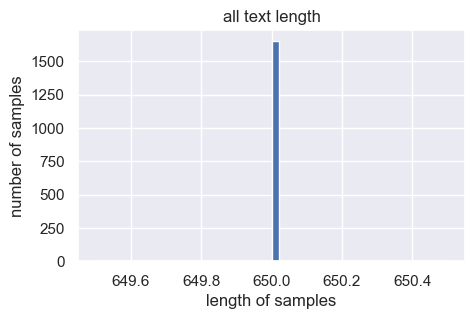

In [32]:
cal_length = train_encoded_electra_1['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

plt.figure(figsize=(5,3))
sns.set_theme(style="darkgrid")
plt.title('all text length')
plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
def cat3_1():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(20, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra_1['input_ids'], train_1.cat3.values,
                                                      test_size=0.2,stratify=train_1.cat3.values ,random_state=777)

In [35]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(2 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(2 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [36]:
model = cat3_1()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [37]:
checkpoint_path = 'checkpoints/koelectra_cat3_detail_1/'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [38]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [39]:
history = model.fit(train_dataset,steps_per_epoch=len(train_1) // 2 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5,
                    callbacks=[cp_callback]
                   )

Epoch 1/5
826/826 [==============================] - 195s 226ms/step - loss: 2.5853 - accuracy: 0.1925 - val_loss: 2.0339 - val_accuracy: 0.3505

Epoch 00001: saving model to checkpoints/koelectra_cat3_detail_1\
Epoch 2/5
826/826 [==============================] - 185s 224ms/step - loss: 1.3948 - accuracy: 0.6114 - val_loss: 1.0789 - val_accuracy: 0.7069

Epoch 00002: saving model to checkpoints/koelectra_cat3_detail_1\
Epoch 3/5
826/826 [==============================] - 184s 223ms/step - loss: 0.7325 - accuracy: 0.8015 - val_loss: 0.8985 - val_accuracy: 0.7583

Epoch 00003: saving model to checkpoints/koelectra_cat3_detail_1\
Epoch 4/5
826/826 [==============================] - 185s 223ms/step - loss: 0.4664 - accuracy: 0.8789 - val_loss: 0.9232 - val_accuracy: 0.7553

Epoch 00004: saving model to checkpoints/koelectra_cat3_detail_1\
Epoch 5/5
826/826 [==============================] - 185s 224ms/step - loss: 0.3527 - accuracy: 0.9044 - val_loss: 0.9555 - val_accuracy: 0.7764

Epoch 

In [ ]:
def cat3_2():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(31, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = cat3_2()

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra_2['input_ids'], train_2.cat3.values,
                                                      test_size=0.2, stratify=train_2.cat3.values ,random_state=777)

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(2 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(2 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
checkpoint_path = 'checkpoints/koelectra_cat3_detail_2/'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history_2 = model.fit(train_dataset,steps_per_epoch=len(train_2) // 2 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5,
                    callbacks=[cp_callback]
                   )

In [33]:
def cat3_3():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(8, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [34]:
model = cat3_3()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [35]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra_3['input_ids'], train_3.cat3.values,
                                                      test_size=0.2, stratify=train_3.cat3.values ,random_state=777)

In [36]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(2 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(2 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [37]:
checkpoint_path = 'checkpoints/koelectra_cat3_detail_3/'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history_3 = model.fit(train_dataset,steps_per_epoch=len(train_3) // 2 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5,
                    callbacks=[cp_callback]
                   )

Epoch 1/5
2456/2456 [==============================] - 558s 224ms/step - loss: 1.0110 - accuracy: 0.7107 - val_loss: 0.6354 - val_accuracy: 0.8464

Epoch 00001: saving model to checkpoints/koelectra_cat3_detail_3\
Epoch 2/5
2456/2456 [==============================] - 547s 223ms/step - loss: 0.3789 - accuracy: 0.8907 - val_loss: 0.2426 - val_accuracy: 0.9430

Epoch 00002: saving model to checkpoints/koelectra_cat3_detail_3\
Epoch 3/5
2456/2456 [==============================] - 549s 223ms/step - loss: 0.2084 - accuracy: 0.9404 - val_loss: 0.2556 - val_accuracy: 0.9359

Epoch 00003: saving model to checkpoints/koelectra_cat3_detail_3\
Epoch 4/5
2456/2456 [==============================] - 548s 223ms/step - loss: 0.1364 - accuracy: 0.9632 - val_loss: 0.2402 - val_accuracy: 0.9410

Epoch 00004: saving model to checkpoints/koelectra_cat3_detail_3\
Epoch 5/5
2456/2456 [==============================] - 547s 223ms/step - loss: 0.0941 - accuracy: 0.9762 - val_loss: 0.2348 - val_accuracy: 0.94

In [33]:
def cat3_4():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(53, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [34]:
model = cat3_4()

x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra_4['input_ids'], train_4.cat3.values,
                                                      test_size=0.2, stratify=train_4.cat3.values ,random_state=777)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(2 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(2 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [35]:
checkpoint_path = 'checkpoints/koelectra_cat3_detail_4/'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history_4 = model.fit(train_dataset,steps_per_epoch=len(train_4) // 2 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5,
                    callbacks=[cp_callback]
                   )

Epoch 1/5
2706/2706 [==============================] - 609s 222ms/step - loss: 2.3686 - accuracy: 0.3915 - val_loss: 1.4486 - val_accuracy: 0.6260

Epoch 00001: saving model to checkpoints/koelectra_cat3_detail_4\
Epoch 2/5
2706/2706 [==============================] - 600s 222ms/step - loss: 1.1455 - accuracy: 0.7053 - val_loss: 1.1179 - val_accuracy: 0.7091

Epoch 00002: saving model to checkpoints/koelectra_cat3_detail_4\
Epoch 3/5
2706/2706 [==============================] - 601s 222ms/step - loss: 0.7969 - accuracy: 0.7846 - val_loss: 1.0477 - val_accuracy: 0.7368

Epoch 00003: saving model to checkpoints/koelectra_cat3_detail_4\
Epoch 4/5
2706/2706 [==============================] - 600s 222ms/step - loss: 0.5620 - accuracy: 0.8400 - val_loss: 1.1597 - val_accuracy: 0.7470

Epoch 00004: saving model to checkpoints/koelectra_cat3_detail_4\
Epoch 5/5
2706/2706 [==============================] - 601s 222ms/step - loss: 0.4280 - accuracy: 0.8793 - val_loss: 1.1404 - val_accuracy: 0.74

In [33]:
def cat3_5():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(9, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [34]:
model = cat3_5()

x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra_5['input_ids'], train_5.cat3.values,
                                                      test_size=0.2, stratify=train_5.cat3.values ,random_state=777)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(2 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(2 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [35]:
checkpoint_path = 'checkpoints/koelectra_cat3_detail_5/'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history_5 = model.fit(train_dataset,steps_per_epoch=len(train_5) // 2 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5,
                    callbacks=[cp_callback]
                   )

Epoch 1/5
701/701 [==============================] - 165s 224ms/step - loss: 1.4793 - accuracy: 0.4593 - val_loss: 1.1659 - val_accuracy: 0.6157

Epoch 00001: saving model to checkpoints/koelectra_cat3_detail_5\
Epoch 2/5
701/701 [==============================] - 156s 222ms/step - loss: 0.8707 - accuracy: 0.7304 - val_loss: 0.8969 - val_accuracy: 0.7224

Epoch 00002: saving model to checkpoints/koelectra_cat3_detail_5\
Epoch 3/5
701/701 [==============================] - 156s 222ms/step - loss: 0.5918 - accuracy: 0.8074 - val_loss: 0.8579 - val_accuracy: 0.7509

Epoch 00003: saving model to checkpoints/koelectra_cat3_detail_5\
Epoch 4/5
701/701 [==============================] - 155s 222ms/step - loss: 0.3725 - accuracy: 0.8823 - val_loss: 0.7443 - val_accuracy: 0.7758

Epoch 00004: saving model to checkpoints/koelectra_cat3_detail_5\
Epoch 5/5
701/701 [==============================] - 156s 222ms/step - loss: 0.2327 - accuracy: 0.9379 - val_loss: 0.7886 - val_accuracy: 0.7758

Epoch 

In [36]:
def cat3_6():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(7, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [37]:
model = cat3_6()

x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra_6['input_ids'], train_6.cat3.values,
                                                      test_size=0.2, stratify=train_6.cat3.values ,random_state=777)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(2 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(2 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [38]:
checkpoint_path = 'checkpoints/koelectra_cat3_detail_6/'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history_6 = model.fit(train_dataset,steps_per_epoch=len(train_6) // 2 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5,
                    callbacks=[cp_callback]
                   )

Epoch 1/5
348/348 [==============================] - 87s 226ms/step - loss: 1.5098 - accuracy: 0.3477 - val_loss: 1.4336 - val_accuracy: 0.3214

Epoch 00001: saving model to checkpoints/koelectra_cat3_detail_6\
Epoch 2/5
348/348 [==============================] - 77s 222ms/step - loss: 0.8345 - accuracy: 0.7328 - val_loss: 0.6686 - val_accuracy: 0.7429

Epoch 00002: saving model to checkpoints/koelectra_cat3_detail_6\
Epoch 3/5
348/348 [==============================] - 77s 222ms/step - loss: 0.5140 - accuracy: 0.8491 - val_loss: 0.8594 - val_accuracy: 0.7357

Epoch 00003: saving model to checkpoints/koelectra_cat3_detail_6\
Epoch 4/5
348/348 [==============================] - 77s 222ms/step - loss: 0.3242 - accuracy: 0.9023 - val_loss: 0.6937 - val_accuracy: 0.7643

Epoch 00004: saving model to checkpoints/koelectra_cat3_detail_6\
Epoch 5/5
348/348 [==============================] - 77s 222ms/step - loss: 0.2722 - accuracy: 0.9167 - val_loss: 0.8979 - val_accuracy: 0.7500

Epoch 00005

## cat1 예측하는 KoELECTRA 불러오기

In [39]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(500,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(6, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [40]:
strategy = tf.distribute.get_strategy()
saved_model = model_KoELECTRA()
saved_model.load_weights('checkpoints/koelectra_cat1/koelectra_checkpoint')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [41]:
electra_tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [42]:
test_data = test['overview'].values.tolist()

In [43]:
test_encoded_electra = electra_tokenizer.batch_encode_plus(test_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


In [44]:
cal_length = test_encoded_electra['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 179.36771978021977
토큰 길이 최대: 3744
토큰 길이 표준편차: 153.0385736649946
설정 최대 길이: 485
전체 문장의 0.9608516483516484%가 설정값인 485에 포함됩니다.


In [45]:
test_encoded_electra = tokenizer.batch_encode_plus(test_data, max_length=500, pad_to_max_length='left')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [46]:
x_test = test_encoded_electra['input_ids']
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(strategy.num_replicas_in_sync))

In [47]:
len(x_test)

7280

In [48]:
pred = saved_model.predict(test_dataset, verbose=1)
pred_arg = pred.argmax(axis=1)

7280/7280 [==============================] - 318s 43ms/step


In [49]:
pred_arg

array([3, 3, 3, ..., 0, 2, 4], dtype=int64)

In [50]:
test['cat1_result'] = pred_arg

In [51]:
test

,id,img_path,overview,cat1_result
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.,3
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ...",3
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...,3
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...,0
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...,5
...,...,...,...,...
7275,TEST_07275,./image/test/TEST_07275.jpg,"막국수와 수육을 주메뉴로 하며, 넓은 주차장이 마련되어 있어 주차하기 편리하다.",3
7276,TEST_07276,./image/test/TEST_07276.jpg,"통진두레문화센터는 우리고유의 전통무형문화와 민속예술을 계승/발전 시키고, 다양한 문...",4
7277,TEST_07277,./image/test/TEST_07277.jpg,"수도권에서 가까운 위치, 문산천을 따라 걷는 산책코스, 한여름 더위를 날려버릴 시원...",0
7278,TEST_07278,./image/test/TEST_07278.jpg,전남 구례군 관산리에 위치한 노고단 게스트하우스&호텔은 지리산을 파노라마로 관망할 ...,2


In [52]:
encoder = LabelEncoder()

encoder.fit(train['cat1'])
train['cat1'] = encoder.transform(train['cat1'])

In [53]:
encoder.classes_

array(['레포츠', '쇼핑', '숙박', '음식', '인문(문화/예술/역사)', '자연'], dtype=object)

In [54]:
test['cat1_result'] = encoder.inverse_transform(test['cat1_result'])

In [55]:
test

,id,img_path,overview,cat1_result
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.,음식
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ...",음식
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...,음식
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...,레포츠
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...,자연
...,...,...,...,...
7275,TEST_07275,./image/test/TEST_07275.jpg,"막국수와 수육을 주메뉴로 하며, 넓은 주차장이 마련되어 있어 주차하기 편리하다.",음식
7276,TEST_07276,./image/test/TEST_07276.jpg,"통진두레문화센터는 우리고유의 전통무형문화와 민속예술을 계승/발전 시키고, 다양한 문...",인문(문화/예술/역사)
7277,TEST_07277,./image/test/TEST_07277.jpg,"수도권에서 가까운 위치, 문산천을 따라 걷는 산책코스, 한여름 더위를 날려버릴 시원...",레포츠
7278,TEST_07278,./image/test/TEST_07278.jpg,전남 구례군 관산리에 위치한 노고단 게스트하우스&호텔은 지리산을 파노라마로 관망할 ...,숙박


In [56]:
test_1 = test[test['cat1_result']=='자연']
test_2 = test[test['cat1_result']=='레포츠']
test_3 = test[test['cat1_result']=='음식'].
test_4 = test[test['cat1_result']=='인문(문화/예술/역사)']
test_5 = test[test['cat1_result']=='숙박']
test_6 = test[test['cat1_result']=='쇼핑']

In [62]:
def cat3_1():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(20, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def cat3_2():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(31, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def cat3_3():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(8, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def cat3_4():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(53, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def cat3_5():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(9, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def cat3_6():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(650,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(7, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [63]:
cat3_1 = cat3_1()
cat3_2 = cat3_2()
cat3_3 = cat3_3()
cat3_4 = cat3_4()
cat3_5 = cat3_5()
cat3_6 = cat3_6()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

ResourceExhaustedError: OOM when allocating tensor with shape[35000,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:AssignVariableOp]

In [64]:
test.to_csv("data/test_cat1_result.csv", index=False, encoding='UTF8')